In [24]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs

import scipy.stats as stats

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [2]:
def standartize(arr):
    return (arr - np.mean(arr))/np.std(arr)

In [5]:
with client.Session() as session:
    query = (session.query(Simulation.id, Simulation.particles, Simulation.group_name)
                 .where(Simulation.group_name.in_(["ER 6.1"] ))
                 .where(Simulation.particles == 343) 
                 .order_by(Simulation.start_time)).all()[:]
# query = [x[1] for x in query]
print(len(query))

100


In [6]:
query[0]

(11831, 343, 'ER 6.1')

In [5]:
%%time
item = client.query_simulation(id=query[0][0], full_load=False)
item.load_history()

CPU times: user 54.8 ms, sys: 131 ms, total: 186 ms
Wall time: 1.91 s


In [6]:
item.history.keys()

dict_keys(['BInertia', 'IE', 'KE', 'L', 'LJ_force', 'OMEGA', 'PE', 'collisions', 'rs', 'time', 'vs'])

In [44]:
delete_list = []
def f(sid):
    
    item = client.query_simulation(id=sid, full_load=False)
    item.load_df()
    item.load_history()
    return item

In [42]:
def smoothen(df, time_window):
    if time_window<0:
        return df
    window = len(df.loc[0:time_window])
    df_smooth = df.rolling(window, center=True).mean()
    
    if "total_L" in df and "Iz" in df and "total_KE" in df and "N" in df:
        df_smooth["omega_MLE"] = df_smooth["total_L"]/df_smooth["Iz"]
        df_smooth["beta_MLE"] = (1/3 * (2 * df["total_KE"] + 
                                        df.omega_MLE**2 * df["Iz"] 
                                        - 2 * df["total_L"] * df.omega_MLE)/df["N"] )**-1 
    return df_smooth

def concat(dfs, key):
    return pd.concat([df[key] for df in dfs],axis=1)


In [45]:
items = [f(x) for x, n, _ in tqdm(query[:1])]
print("items to delete: ",len(delete_list))


100%|██████████| 1/1 [00:12<00:00, 12.71s/it]

items to delete:  0


In [46]:
item = items[0]

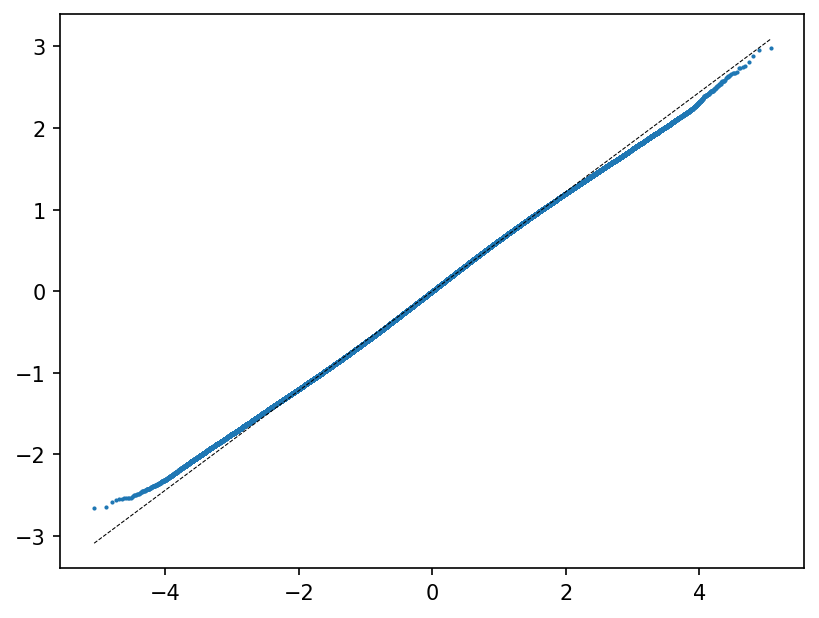

In [47]:
((osm, osr), (slope, intercept, _r)) = stats.probplot(
            item.history["rs"][-10000:,0].flatten(), dist="norm")
sp=1    
plt.scatter(osm[::sp], osr[::sp], s=1)
plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)

In [48]:
(item.history["rs"][-10000:]**2).mean(axis=(0,2)) * np.array([item.a, item.b, item.c])**(-2)

array([0.36406702, 0.36353559, 0.35863119])

In [49]:
(item.history["vs"][-10000:]**2).mean(axis=(0,2))

array([0.3119838 , 0.3115041 , 0.30583736], dtype=float32)

In [52]:
item.history

{'BInertia': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'IE': array([[-0.00235907, -0.00235907, -0.00242993, ..., -0.00242993,
         -0.00235907, -0.00235907],
        [-0.00313192, -0.00272993, -0.00177227, ..., -0.00957922,
         -0.00722583, -0.00219392],
        [-0.00482326, -0.00665683, -0.00202834, ..., -0.04053532,
         -0.02242805, -0.00260043],
        ...,
        [-0.08383726, -0.03297794, -0.02460971, ..., -0.03173838,
         -0.03705496,  0.69789004],
        [-0.03104713, -0.00116818,  0.01246466, ..., -0.04276819,
         -0.05485319, -0.08012351],
        [-0.05396714, -0.01855723, -0.0378124 , ...,  0.31620556,
         -0.02917635, -0.05661842]], dtype=float32),
 'KE': array([[0.8210238 , 0.7321569 , 1.0008665 , ..., 0.62743556, 0.977656

In [54]:
item.df.omega_MLE

time
0.000000        0.930788
0.200000        0.937832
0.400000        0.944967
0.600000        0.934879
0.800000        0.915244
                  ...   
9999.200195     0.120853
9999.400391     0.116074
9999.599609     0.113153
9999.799805     0.112189
10000.000000    0.113113
Name: omega_MLE, Length: 50001, dtype: float32

In [55]:
item.a

1.0102577523383118

In [56]:
item.b

0.989846400767953